In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models


input_path = 'lab.jpg'
output_path_jpeg = 'compressed.jpg'
output_path_png = 'compressed.png'
quality_jpeg = 50
quality_png = 9

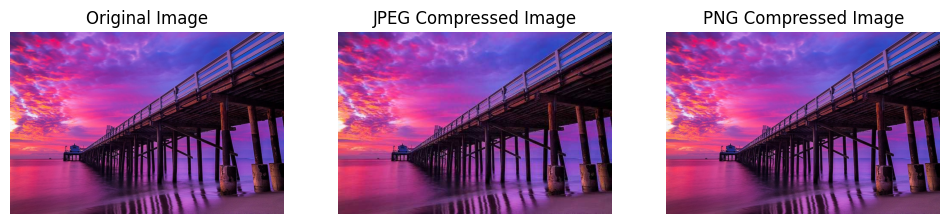

In [ ]:
img = cv2.imread(input_path)
cv2.imwrite(output_path_jpeg, img, [int(cv2.IMWRITE_JPEG_QUALITY), quality_jpeg])
cv2.imwrite(output_path_png, img, [int(cv2.IMWRITE_PNG_COMPRESSION), quality_png])

# Display Original and Compressed Images
original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
jpeg_compressed = cv2.cvtColor(cv2.imread(output_path_jpeg), cv2.COLOR_BGR2RGB)
png_compressed = cv2.cvtColor(cv2.imread(output_path_png), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(jpeg_compressed)
plt.title("JPEG Compressed Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(png_compressed)
plt.title("PNG Compressed Image")
plt.axis("off")

plt.show()

Original Image Size: 10.34 KB
Compressed Image Size: 8.61 KB
Compression Ratio: 1.20


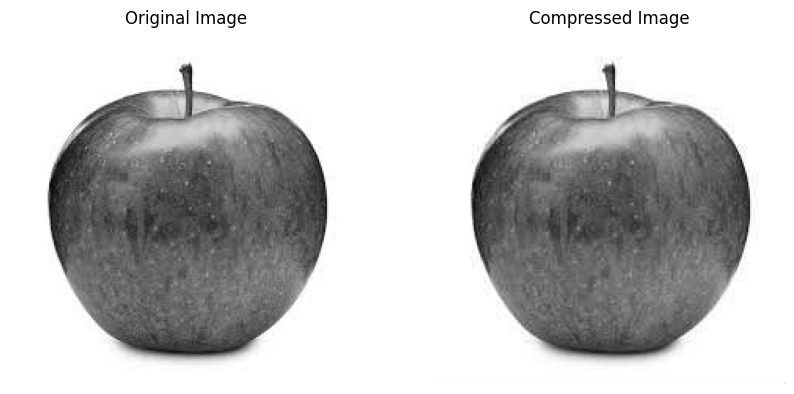

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)


    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            # Apply DCT to the block
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)


    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            # Apply Inverse DCT to the block
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed


def blockwise_quantize_dct(dct_image, quant_matrix, block_size=8):
    """Quantizes the DCT coefficients block-wise."""
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_block = np.round(block / quant_matrix)  # Quantization
            quantized_dct[i:i + block_size, j:j + block_size] = quantized_block

    return quantized_dct

def blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size=8):
    """Dequantizes the DCT coefficients block-wise."""
    h, w = quantized_dct.shape
    dequantized_dct = np.zeros_like(quantized_dct, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct[i:i + block_size, j:j + block_size]
            dequantized_block = block * quant_matrix  # Dequantization
            dequantized_dct[i:i + block_size, j:j + block_size] = dequantized_block

    return dequantized_dct



import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = "apple.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Pad the image to make its dimensions a multiple of 8
h, w = image.shape
new_h = (h + 7) // 8 * 8
new_w = (w + 7) // 8 * 8
padded_image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)

# Define an 8x8 quantization matrix (for simplicity, a JPEG-like matrix)
quant_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])


dct_image = blockwise_dct(padded_image)


quantized_dct = blockwise_quantize_dct(dct_image, quant_matrix)


dequantized_dct = blockwise_dequantize_dct(quantized_dct, quant_matrix)


image_reconstructed = blockwise_idct(dequantized_dct)


image_reconstructed = image_reconstructed[:h, :w]

# Clip the values to be in the 8-bit range and convert to uint8
image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

# Display the original and the compressed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Compressed Image')
plt.axis('off')

import os


original_image_path = "original_image.jpg"
cv2.imwrite(original_image_path, image)

compressed_image_path = "compressed_image.jpg"
cv2.imwrite(compressed_image_path, image_reconstructed)


original_size = os.path.getsize(original_image_path)
compressed_size = os.path.getsize(compressed_image_path)


print(f"Original Image Size: {original_size / 1024:.2f} KB")
print(f"Compressed Image Size: {compressed_size / 1024:.2f} KB")
print(f"Compression Ratio: {original_size / compressed_size:.2f}")


plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 140ms/step - accuracy: 0.8280 - loss: 0.5730 - val_accuracy: 0.9804 - val_loss: 0.0607
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/step - accuracy: 0.9785 - loss: 0.0693 - val_accuracy: 0.9848 - val_loss: 0.0449
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 106ms/step - accuracy: 0.9874 - loss: 0.0407 - val_accuracy: 0.9859 - val_loss: 0.0427
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 112ms/step - accuracy: 0.9906 - loss: 0.0314 - val_accuracy: 0.9897 - val_loss: 0.0335
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - accuracy: 0.9910 - loss: 0.0281 - val_accuracy: 0.9884 - val_loss: 0.0371
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.9928 - loss: 0.0226 - val_accuracy: 0.9901 - val_loss: 0.0334
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - accuracy: 0.9945 - loss: 0.0174 - val_accuracy: 0.9919 - val_loss: 0.0311
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - accuracy: 0.9956 - loss: 0

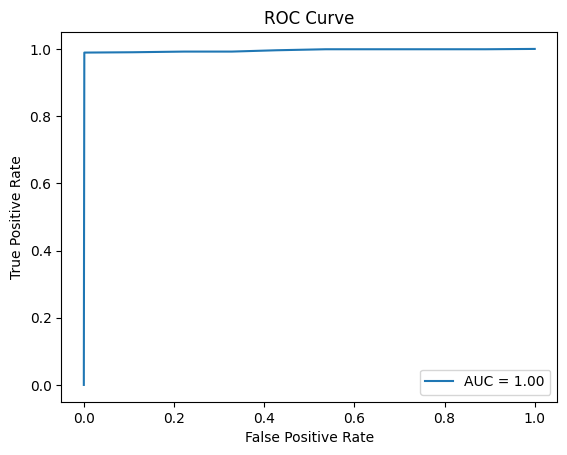

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]


model_mnist = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_mnist.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_mnist.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))
y_pred = model_mnist.predict(x_test).argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=y_test.max())
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 84ms/step - accuracy: 0.3075 - loss: 1.8473 - val_accuracy: 0.5017 - val_loss: 1.3551
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 91ms/step - accuracy: 0.5324 - loss: 1.3015 - val_accuracy: 0.5669 - val_loss: 1.2226
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 83ms/step - accuracy: 0.6059 - loss: 1.1079 - val_accuracy: 0.6265 - val_loss: 1.0720
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 86ms/step - accuracy: 0.6501 - loss: 0.9947 - val_accuracy: 0.6596 - val_loss: 0.9821
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.6781 - loss: 0.9111 - val_accuracy: 0.6725 - val_loss: 0.9342
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 89ms/step - accuracy: 0.7046 - loss: 0.8484 - val_accuracy: 0.6923 - val_loss: 0.8975
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 86ms/step - accuracy: 0.7190 - loss: 0.7953 - val_accuracy: 0.6915 - val_loss: 0.9029
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.7379 - loss: 0.7484 - 

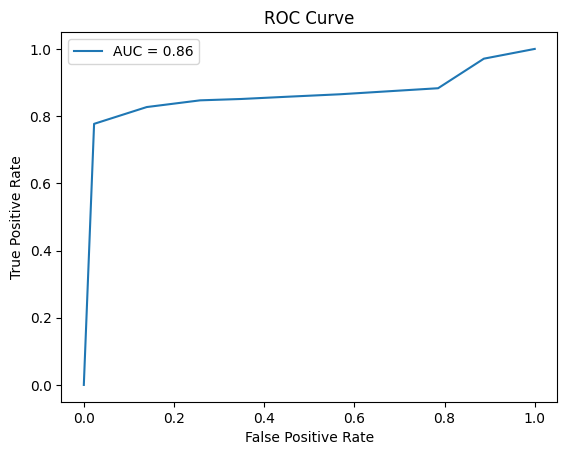

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


model_cifar10 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_cifar10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cifar10.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test))
y_pred = model_cifar10.predict(x_test).argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=y_test.max())
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
